🔍 Found 18 image-mask pairs in C:\Users\ISU\cv_dataset\os_dataset\train1
🔍 Found 7 image-mask pairs in C:\Users\ISU\cv_dataset\os_dataset\val1
🔍 Found 3 image-mask pairs in C:\Users\ISU\cv_dataset\os_dataset\test1
Visualizing a sample image and mask from training data...


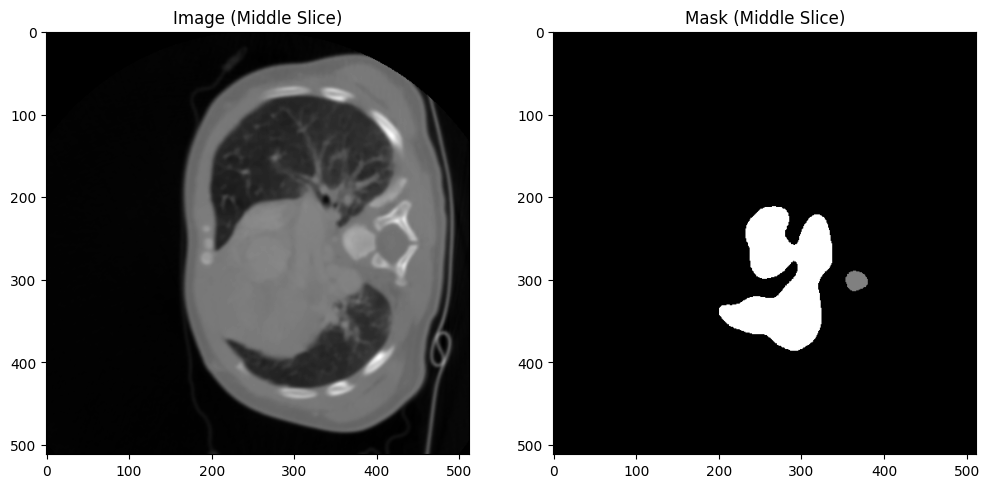

Class distribution in the training set:
  Class 0: 1064756928 pixels
  Class 1: 2632211 pixels
  Class 2: 20997475 pixels
  Class 3: 1106800 pixels
❌ The specific training image 'pat0(SCAN) (1).nrrd' was not found in the training data.
❌ The specific training mask 'pat0(Mask).nrrd' was not found in the training data.


FileNotFoundError: Required overfit training files not found in the specified directories.

In [3]:
import os
import glob
import torch
import nrrd
import nibabel as nib
import scipy.ndimage
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import re
import matplotlib.pyplot as plt

# --- Configuration ---
INPUT_SHAPE = (128, 128, 64)  # Resize images to this shape
BATCH_SIZE = 2
EPOCHS = 10  # (unused main training loop removed)
OVERFIT_EPOCHS = 35  # Number of epochs for overfit sanity check
LEARNING_RATE = 1e-4
NUM_CLASSES = 4  # (class 0 = background, classes 1..3 = foreground)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEBUG = True  # Set to True to enable deep debug prints

# Dataset Paths
BASE_DIR = r"C:\Users\ISU\cv_dataset\os_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train1")
VAL_DIR = os.path.join(BASE_DIR, "val1")
TEST_DIR = os.path.join(BASE_DIR, "test1")
OUTPUT_MASK_PATH = os.path.join(TEST_DIR, "predictionsOverfit")
os.makedirs(OUTPUT_MASK_PATH, exist_ok=True)

# --- Load Medical Images ---
def load_medical_image(file_path):
    ext = file_path.split('.')[-1].lower()
    if ext in ['nii', 'nii.gz']:
        img = nib.load(file_path)
        data = img.get_fdata()
    elif ext == 'nrrd':
        data, _ = nrrd.read(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_path}")
    return np.array(data)

# --- Image-Mask Pairing ---
def get_image_mask_pairs(directory):
    image_files = glob.glob(os.path.join(directory, "images", "*"))
    mask_files = glob.glob(os.path.join(directory, "masks", "*"))

    def get_basename(file_path):
        base = os.path.basename(file_path).split('.')[0]
        # Remove suffixes like _seg, (SCAN), (MASK), (mask), (scan)
        base = re.sub(r'(_seg|\(SCAN\)|\(MASK\)|\(mask\)|\(scan\))$', '', base)
        return base

    image_dict = {get_basename(f): f for f in image_files}
    mask_dict = {get_basename(f): f for f in mask_files}

    common_keys = set(image_dict.keys()) & set(mask_dict.keys())
    images = [image_dict[key] for key in common_keys]
    masks = [mask_dict[key] for key in common_keys]

    if len(common_keys) == 0:
        print("❌ No matching images and masks found. Check filenames!")
    else:
        print(f"🔍 Found {len(images)} image-mask pairs in {directory}")

    return images, masks

# --- Preprocessing Functions ---
def preprocess_image(img, shape=INPUT_SHAPE, order=1):
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    zoom_factors = [shape[i] / img.shape[i] for i in range(3)]
    return scipy.ndimage.zoom(img, zoom_factors, order=order)

def preprocess_mask(mask, shape=INPUT_SHAPE, order=0):
    zoom_factors = [shape[i] / mask.shape[i] for i in range(3)]
    return scipy.ndimage.zoom(mask, zoom_factors, order=order)

# --- Debug Visualization for a Sample (from disk) ---
def debug_visualize_sample(image_path, mask_path):
    """Visualize the middle slice of a 3D image and its corresponding mask."""
    img = load_medical_image(image_path)
    mask = load_medical_image(mask_path)
    mid_slice = img.shape[2] // 2
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img[:, :, mid_slice], cmap="gray")
    plt.title("Image (Middle Slice)")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[:, :, mid_slice], cmap="gray")
    plt.title("Mask (Middle Slice)")
    plt.show()

# --- Visualization for Predictions ---
def visualize_prediction(image, ground_truth, prediction, title="Prediction Visualization"):
    """
    Visualizes the middle slice of a 3D image, ground truth mask, and predicted mask.
    image: numpy array (3D)
    ground_truth: numpy array (3D)
    prediction: numpy array (3D)
    """
    mid_slice = image.shape[2] // 2
    plt.figure(figsize=(18, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, mid_slice], cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth[:, :, mid_slice], cmap="gray")
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[:, :, mid_slice], cmap="gray")
    plt.title("Predicted Mask")
    
    plt.show()

# --- Enhanced Augmentation Function ---
def enhanced_augment(image, mask):
    # Random Flips
    for axis in range(3):
        if random.random() > 0.5:
            image = np.flip(image, axis=axis).copy()
            mask = np.flip(mask, axis=axis).copy()

    # Random Rotations
    angle_range = (-10, 10)
    for axis in range(3):
        angle = random.uniform(*angle_range)
        if axis == 0:
            rot_axes = (1, 2)
        elif axis == 1:
            rot_axes = (0, 2)
        else:
            rot_axes = (0, 1)
        image = scipy.ndimage.rotate(image, angle, axes=rot_axes, reshape=False, order=1, mode='nearest')
        mask = scipy.ndimage.rotate(mask, angle, axes=rot_axes, reshape=False, order=0, mode='nearest')

    # Random Translations
    max_shift = 10
    shifts = [random.uniform(-max_shift, max_shift) for _ in range(3)]
    image = scipy.ndimage.shift(image, shift=shifts, order=1, mode='nearest')
    mask = scipy.ndimage.shift(mask, shift=shifts, order=0, mode='nearest')

    # Random Scaling
    zoom_factor = random.uniform(0.9, 1.1)
    image = scipy.ndimage.zoom(image, zoom_factor, order=1)
    mask = scipy.ndimage.zoom(mask, zoom_factor, order=0)

    # Crop or Pad to Original Shape
    target_shape = INPUT_SHAPE
    def crop_or_pad(img, target_shape):
        current_shape = img.shape
        pad_width = []
        for cur, target in zip(current_shape, target_shape):
            total_pad = max(target - cur, 0)
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_width.append((pad_before, pad_after))
        img = np.pad(img, pad_width, mode='constant')
        current_shape = img.shape
        slices = []
        for cur, target in zip(current_shape, target_shape):
            start = (cur - target) // 2
            slices.append(slice(start, start + target))
        return img[tuple(slices)]
    image = crop_or_pad(image, target_shape)
    mask = crop_or_pad(mask, target_shape)

    return image, mask

# --- Dataset Class with Augmentation ---
class MedicalDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def resize_3d(self, img, shape, order=0):
        zoom_factors = [shape[i] / img.shape[i] for i in range(3)]
        return scipy.ndimage.zoom(img, zoom_factors, order=order)

    def __getitem__(self, idx):
        img = load_medical_image(self.image_paths[idx])
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = self.resize_3d(img, INPUT_SHAPE, order=1)
        
        if self.mask_paths:
            mask = load_medical_image(self.mask_paths[idx])
            mask = self.resize_3d(mask, INPUT_SHAPE, order=0)
            if self.augmentations:
                img, mask = enhanced_augment(img, mask)
                # Optional: Save visualization for debugging (~10% chance)
                if DEBUG and random.random() < 0.1:
                    visualize_prediction(img, mask, mask, title="Augmented Sample")
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
            mask = torch.tensor(mask, dtype=torch.long)
            return img, mask
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
            return img

# --- Enhanced 3D U-Net with Skip Connections ---
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = conv_block(128, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)  # concatenated with enc3
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        bottleneck = self.bottleneck(self.pool3(enc3))
        dec3 = self.up3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        logits = self.out_conv(dec1)
        if DEBUG:
            print("=== Forward Pass Debug ===")
            print("Input shape:", x.shape)
            print("Enc1 shape:", enc1.shape)
            print("Enc2 shape:", enc2.shape)
            print("Enc3 shape:", enc3.shape)
            print("Bottleneck shape:", bottleneck.shape)
            print("Logits shape:", logits.shape)
            print("==========================")
        return logits

# --- Differentiable Dice Loss Function ---
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_one_hot).sum(dim=(2, 3, 4))
        union = preds.sum(dim=(2, 3, 4)) + targets_one_hot.sum(dim=(2, 3, 4))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# --- Focal Loss to Address Class Imbalance ---
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Combined Loss Function (Dice + Focal Loss) ---
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, weight=None, gamma=2, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(num_classes, smooth)
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma)

    def forward(self, preds, targets):
        return self.dice_loss(preds, targets) + self.focal_loss(preds, targets)

# --- Class Weighting Setup (foreground classes weighted higher) ---
ce_weight = torch.tensor([0.1, 2.0, 2.0, 2.0]).to(DEVICE)
criterion = CombinedLoss(NUM_CLASSES, weight=ce_weight)

# --- Load Data ---
train_img_paths, train_mask_paths = get_image_mask_pairs(TRAIN_DIR)
val_img_paths, val_mask_paths = get_image_mask_pairs(VAL_DIR)
test_img_paths, test_mask_paths = get_image_mask_pairs(TEST_DIR)  # For visualization during training and final evaluation

train_dataset = MedicalDataset(train_img_paths, train_mask_paths, augmentations=True)
val_dataset = MedicalDataset(val_img_paths, val_mask_paths, augmentations=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------- Debug: Visualize a Few Samples ----------
if DEBUG and len(train_img_paths) > 0:
    print("Visualizing a sample image and mask from training data...")
    debug_visualize_sample(train_img_paths[0], train_mask_paths[0])

# ---------- Check Class Imbalance ----------
def compute_class_distribution(mask_paths, num_classes=NUM_CLASSES):
    counts = np.zeros(num_classes)
    for mpath in mask_paths:
        mask = load_medical_image(mpath)
        for cls in range(num_classes):
            counts[cls] += np.sum(mask == cls)
    print("Class distribution in the training set:")
    for cls in range(num_classes):
        print(f"  Class {cls}: {counts[cls]:.0f} pixels")
        
compute_class_distribution(train_mask_paths)

# ---------- Overfit Sanity Check on a Single Sample ----------
specific_image_filename = "pat0(SCAN) (1).nrrd"
specific_mask_filename = "pat0(Mask).nrrd"

# Filter the training image and mask paths to use only the specified files
overfit_img_paths = [p for p in train_img_paths if os.path.basename(p) == specific_image_filename]
overfit_mask_paths = [p for p in train_mask_paths if os.path.basename(p) == specific_mask_filename]

# Check if both files were found
if not overfit_img_paths:
    print(f"❌ The specific training image '{specific_image_filename}' was not found in the training data.")
if not overfit_mask_paths:
    print(f"❌ The specific training mask '{specific_mask_filename}' was not found in the training data.")

if overfit_img_paths and overfit_mask_paths:
    print(f"Using specific training image for overfitting: {overfit_img_paths[0]}")
    print(f"Using specific training mask for overfitting: {overfit_mask_paths[0]}")
else:
    # Exit or handle error as appropriate if the files are not found
    raise FileNotFoundError("Required overfit training files not found in the specified directories.")

# Check that the test folder has at least one image-mask pair for ground truth evaluation
if len(test_img_paths) == 0 or len(test_mask_paths) == 0:
    print("❌ No test images or masks found. Please ensure that the test folder contains at least one image and its corresponding mask for ground truth evaluation.")

overfit_dataset = MedicalDataset(overfit_img_paths, overfit_mask_paths, augmentations=False)
overfit_loader = DataLoader(overfit_dataset, batch_size=1, shuffle=True)



# Create a separate model for overfitting
model_overfit = UNet3D(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
optimizer_overfit = optim.Adam(model_overfit.parameters(), lr=LEARNING_RATE)

print("\nStarting overfit sanity check on a single sample...")
for epoch in range(OVERFIT_EPOCHS):
    model_overfit.train()
    for imgs, masks in overfit_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer_overfit.zero_grad()
        outputs = model_overfit(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer_overfit.step()
    
    print(f"Overfit Epoch {epoch+1:02d}, Loss: {loss.item():.4f}")
    
    # Every 5 epochs, use a test sample for visualization
    if (epoch + 1) % 5 == 0 and len(test_img_paths) > 0:
        # Load the first test sample
        test_img = load_medical_image(test_img_paths[0])
        test_mask = load_medical_image(test_mask_paths[0])
        # Preprocess the test image and mask
        test_img_proc = preprocess_image(test_img, INPUT_SHAPE, order=1)
        test_mask_proc = preprocess_mask(test_mask, INPUT_SHAPE, order=0)
        test_tensor = torch.tensor(test_img_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
        
        model_overfit.eval()
        with torch.no_grad():
            test_output = model_overfit(test_tensor)
            probabilities = F.softmax(test_output, dim=1)
            predicted_test_mask = torch.argmax(probabilities, dim=1)
        # Visualize the test sample prediction
        visualize_prediction(test_img_proc, test_mask_proc, predicted_test_mask.cpu().squeeze().numpy(), 
                               title=f"Test Sample Prediction at Epoch {epoch+1}")

# ---------- Inference & Evaluation ----------
def compute_metrics(pred, target, num_classes=NUM_CLASSES, smooth=1e-6):
    dice_scores = []
    jaccard_scores = []
    per_class_metrics = {}
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.float32)
        target_cls = (target == cls).astype(np.float32)
        intersection = np.sum(pred_cls * target_cls)
        union = np.sum(pred_cls) + np.sum(target_cls)
        dice = (2 * intersection + smooth) / (union + smooth)
        jaccard = (intersection + smooth) / (np.sum(pred_cls) + np.sum(target_cls) - intersection + smooth)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)
        per_class_metrics[f'class_{cls}'] = {'dice': dice, 'jaccard': jaccard}
    pixel_accuracy = np.mean(pred.flatten() == target.flatten())
    mean_dice = np.mean(dice_scores)
    mean_jaccard = np.mean(jaccard_scores)
    return per_class_metrics, mean_dice, mean_jaccard, pixel_accuracy

model_overfit.eval()  # Using the overfit model for final evaluation on test set

dice_list = []
iou_scores = []
accuracies = []
per_class_results = []

for img_path, mask_path in zip(test_img_paths, test_mask_paths):
    img = load_medical_image(img_path)
    mask_gt = load_medical_image(mask_path)
    
    img = preprocess_image(img, INPUT_SHAPE, order=1)
    mask_gt = preprocess_mask(mask_gt, INPUT_SHAPE, order=0)
    
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model_overfit(img_tensor)
        if DEBUG:
            print("=== Inference Debug ===")
            print("Logits shape:", output.shape)
        probabilities = F.softmax(output, dim=1)
        predicted_mask = torch.argmax(probabilities, dim=1)
    
    # Save predicted mask
    basename = os.path.basename(img_path)
    if basename.endswith('.nrrd'):
        output_filename = os.path.join(OUTPUT_MASK_PATH, basename.replace(".nrrd", "_pred.nrrd"))
    else:
        output_filename = os.path.join(OUTPUT_MASK_PATH, basename + "_pred.nrrd")
    nrrd.write(output_filename, predicted_mask.cpu().numpy())
    print(f"Mask saved to: {output_filename}")
    
    per_class_metrics, mean_dice, mean_jaccard, pixel_accuracy = compute_metrics(predicted_mask.cpu().numpy(), mask_gt)
    dice_list.append(mean_dice)
    iou_scores.append(mean_jaccard)
    accuracies.append(pixel_accuracy)
    per_class_results.append(per_class_metrics)

print("\n--- Evaluation Metrics ---")
print(f"Mean Dice Coefficient: {np.mean(dice_list):.4f}")
print(f"Mean Jaccard Index (IoU): {np.mean(iou_scores):.4f}")
print(f"Mean Pixel Accuracy: {np.mean(accuracies):.4f}")

print("\nPer-Class Metrics (for last sample):")
for cls, metrics in per_class_results[-1].items():
    print(f"{cls}: Dice = {metrics['dice']:.4f}, Jaccard = {metrics['jaccard']:.4f}")

print("Inference complete. Masks saved in the directory:", OUTPUT_MASK_PATH)


In [7]:
import os

def list_all_files(directory):
    """Recursively list all files in a directory."""
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

# Define your training directory (adjust as needed)
TRAIN_DIR = r"C:\Users\musab\cv_dataset\os_dataset\train1"

# Define subdirectories for images and masks
train_image_folder = os.path.join(TRAIN_DIR, "images")
train_mask_folder = os.path.join(TRAIN_DIR, "masks")

# Recursively list all files in the images subfolder
train_image_files = list_all_files(train_image_folder)
print("Training Images:")
for img_file in train_image_files:
    print(img_file)

# Recursively list all files in the masks subfolder
train_mask_files = list_all_files(train_mask_folder)
print("\nTraining Masks:")
for mask_file in train_mask_files:
    print(mask_file)


Training Images:

Training Masks:


In [10]:
import os

def list_all_files(directory):
    """Recursively list all files in a directory."""
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return []
    
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    
    if not file_list:
        print(f"No files found in: {directory}")
    return file_list

# Define your training directory
TRAIN_DIR = r"C:\Users\ISU\cv_dataset\os_dataset\train1"

# Define subdirectories for images and masks
train_image_folder = os.path.join(TRAIN_DIR, "images")
train_mask_folder = os.path.join(TRAIN_DIR, "masks")

# Recursively list all files in the images subfolder
train_image_files = list_all_files(train_image_folder)
print(f"Found {len(train_image_files)} training images.")
for img_file in train_image_files:
    print(img_file)

# Recursively list all files in the masks subfolder
train_mask_files = list_all_files(train_mask_folder)
print(f"\nFound {len(train_mask_files)} training masks.")
for mask_file in train_mask_files:
    print(mask_file)


Found 19 training images.
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-12(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-14(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-15(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-16(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-17(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-18(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-19(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-20(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-21(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-22(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-28(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-35(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-36(SCAN).nrrd
C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-37(SCAN).nrrd
C:\Users\ISU\cv_datase

🔍 Found 19 image-mask pairs in C:\Users\ISU\cv_dataset\os_dataset\train1
🔍 Found 7 image-mask pairs in C:\Users\ISU\cv_dataset\os_dataset\val1
🔍 Found 3 image-mask pairs in C:\Users\ISU\cv_dataset\os_dataset\test1
Visualizing a sample image and mask from training data...


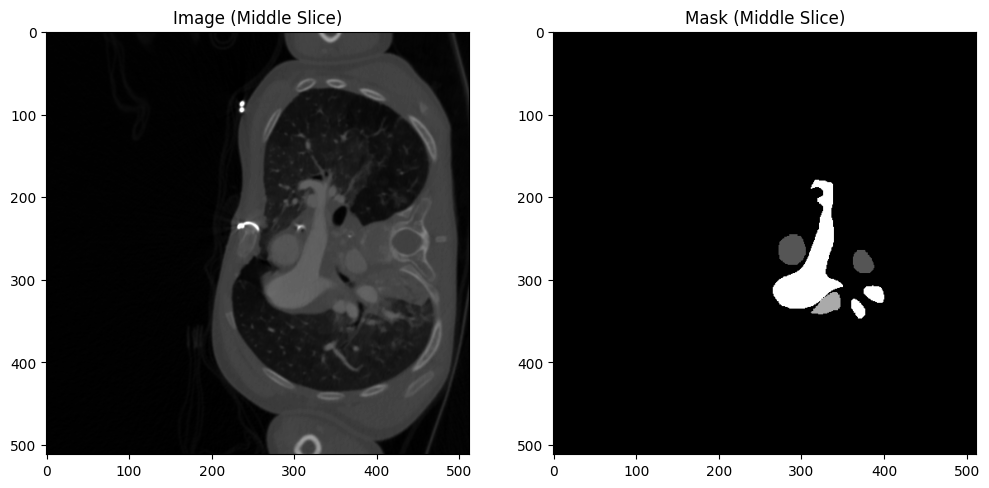

Class distribution in the training set:
  Class 0: 1086261922 pixels
  Class 1: 2707879 pixels
  Class 2: 21464965 pixels
  Class 3: 1177048 pixels
Using specific training image for overfitting: C:\Users\ISU\cv_dataset\os_dataset\train1\images\MEDI-111(SCAN).nrrd
Using specific training mask for overfitting: C:\Users\ISU\cv_dataset\os_dataset\train1\masks\MEDI-111(MASK).nrrd

Starting overfit sanity check on a single sample...
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 01, Loss: 0.9719
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.S

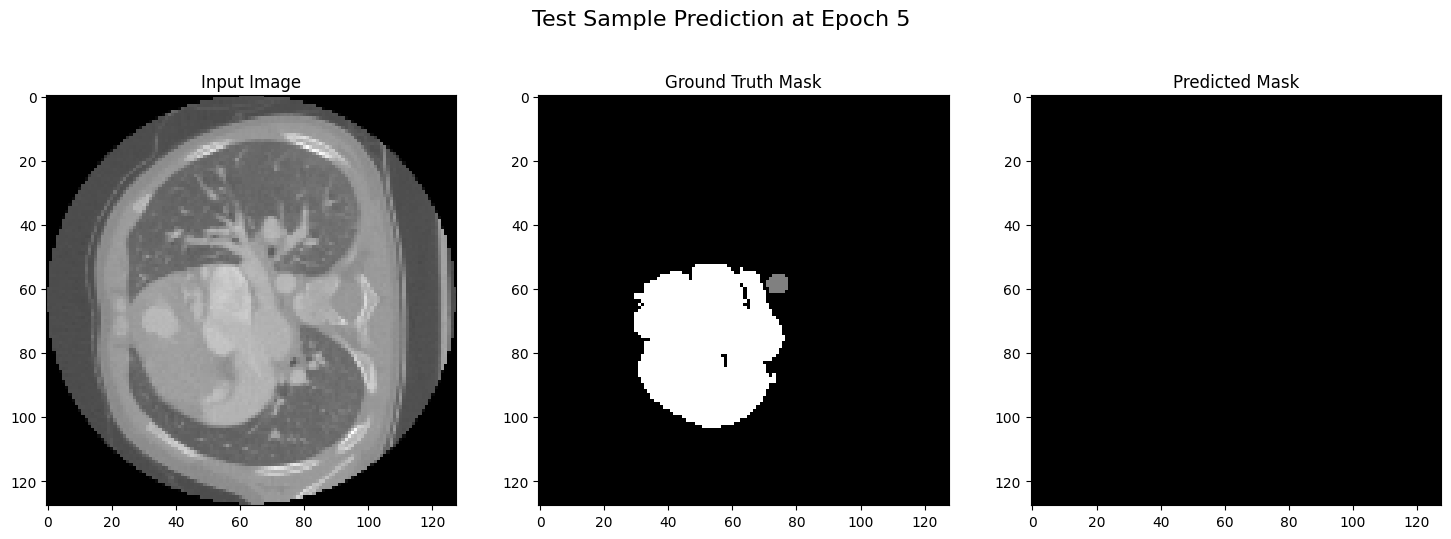

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 06, Loss: 0.9190
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 07, Loss: 0.9131
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 08, Loss:

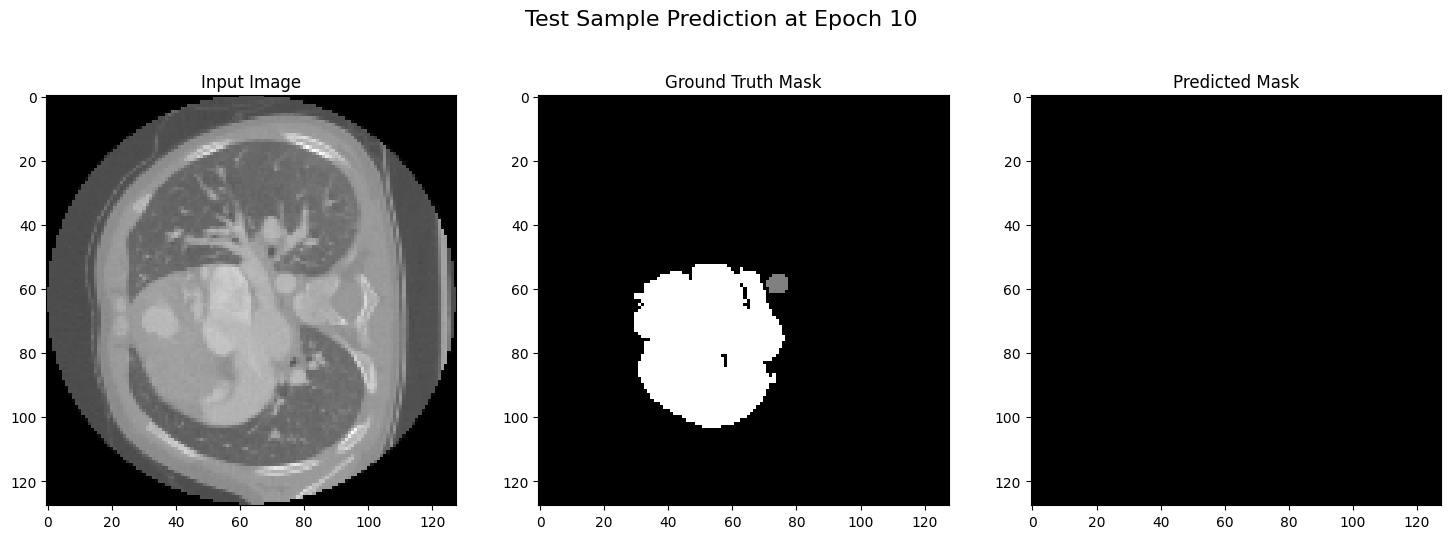

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 11, Loss: 0.8907
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 12, Loss: 0.8850
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 13, Loss:

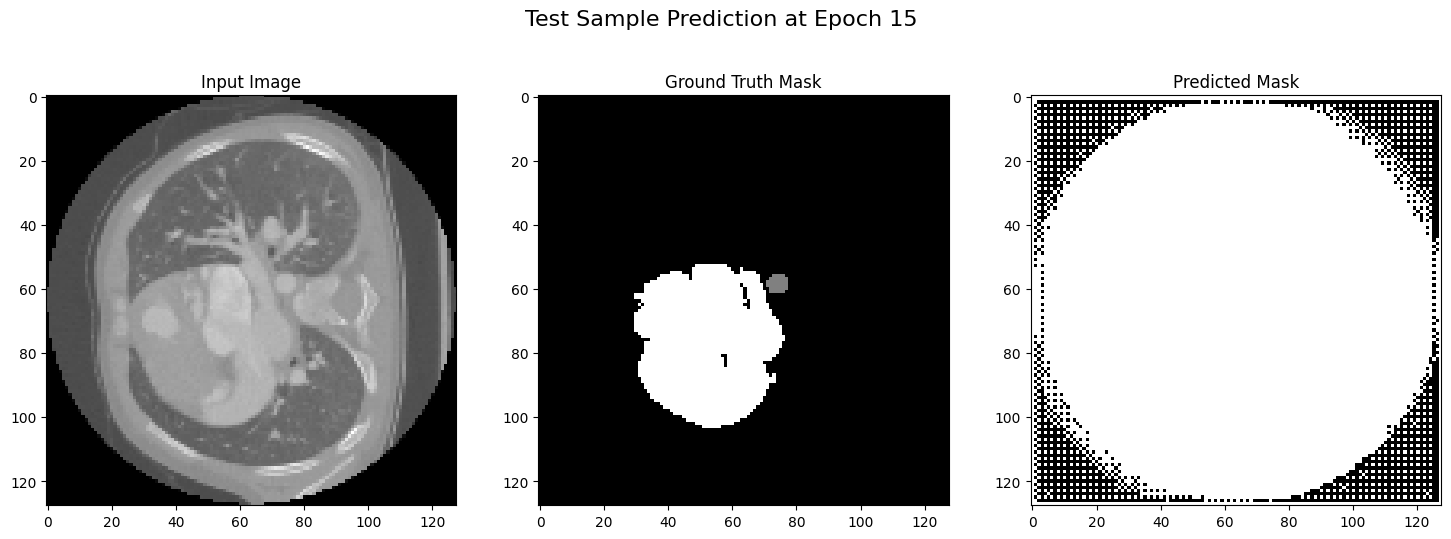

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 16, Loss: 0.8693
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 17, Loss: 0.8656
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 18, Loss:

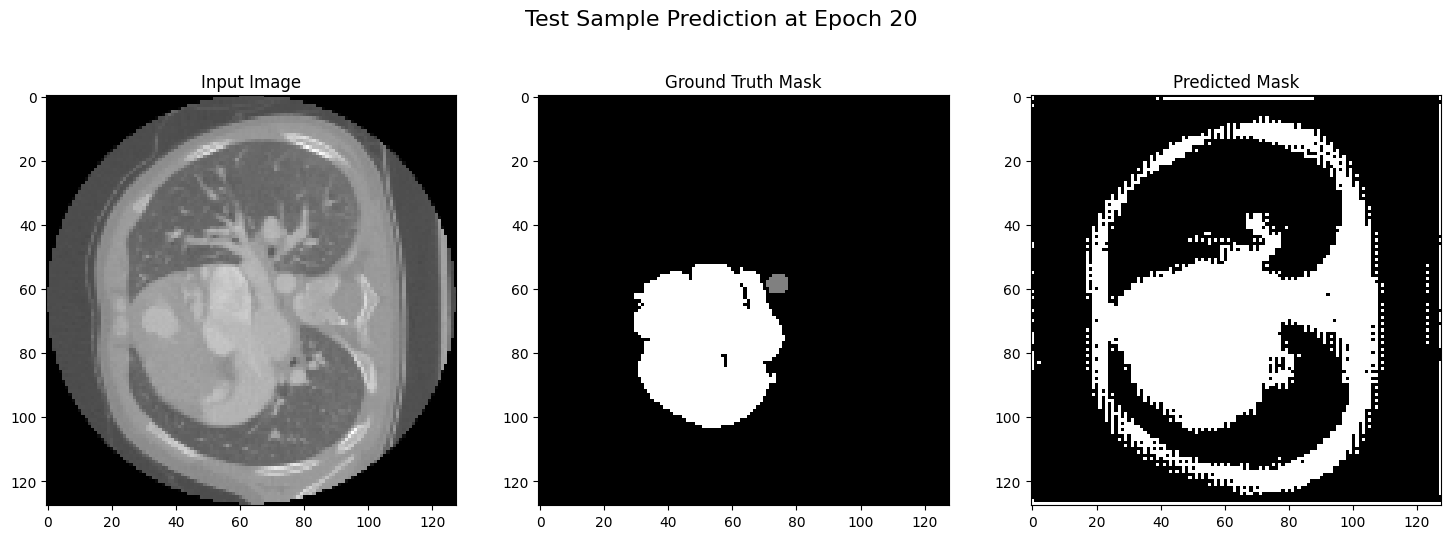

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 21, Loss: 0.8598
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 22, Loss: 0.8552
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 23, Loss:

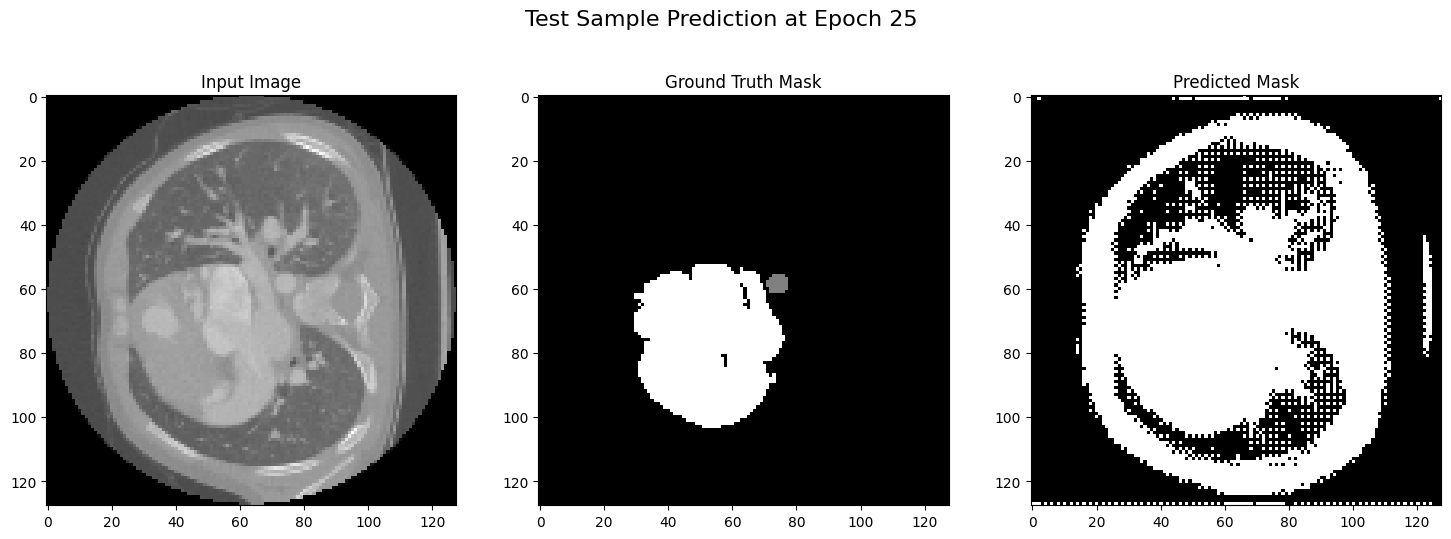

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 26, Loss: 0.8491
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 27, Loss: 0.8468
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 28, Loss:

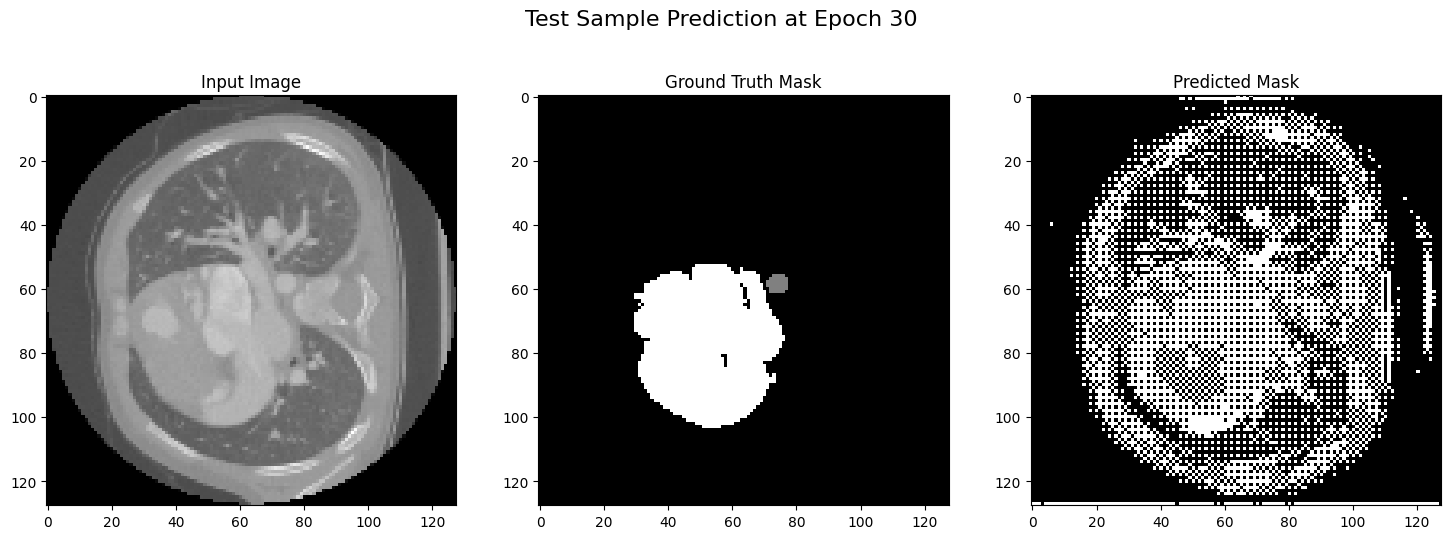

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 31, Loss: 0.8413
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 32, Loss: 0.8398
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
Overfit Epoch 33, Loss:

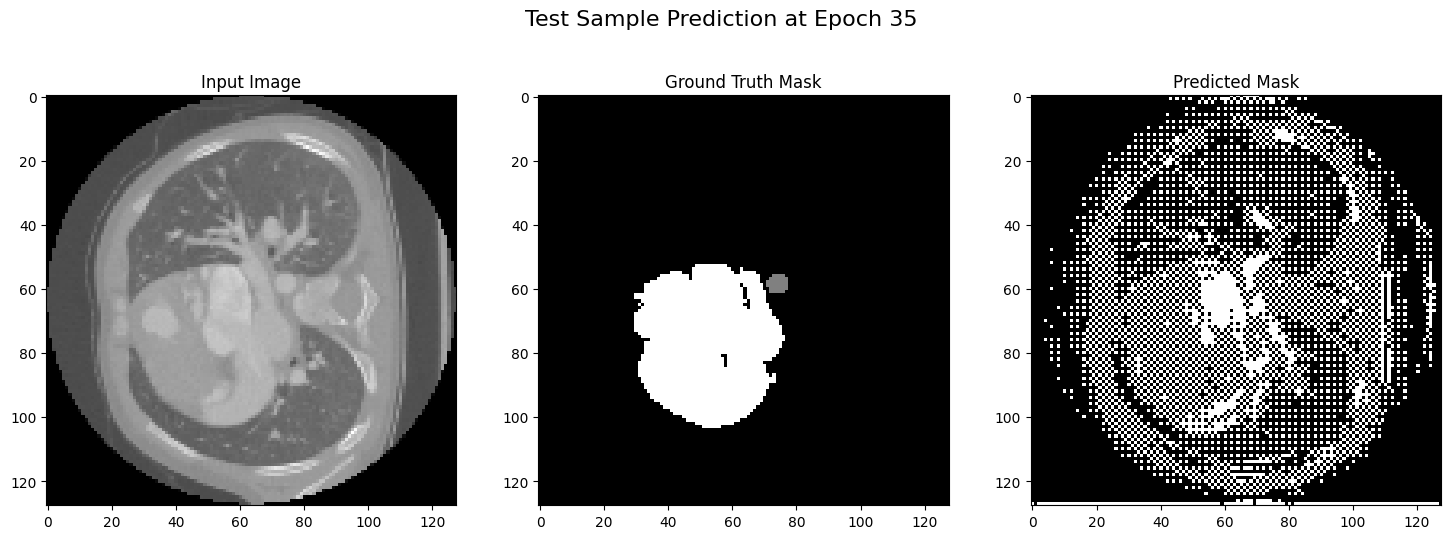

=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
=== Inference Debug ===
Logits shape: torch.Size([1, 4, 128, 128, 64])
Mask saved to: C:\Users\ISU\cv_dataset\os_dataset\test1\predictionsOverfit\IMAEH-1(SCAN)_pred.nrrd
=== Forward Pass Debug ===
Input shape: torch.Size([1, 1, 128, 128, 64])
Enc1 shape: torch.Size([1, 32, 128, 128, 64])
Enc2 shape: torch.Size([1, 64, 64, 64, 32])
Enc3 shape: torch.Size([1, 128, 32, 32, 16])
Bottleneck shape: torch.Size([1, 256, 16, 16, 8])
Logits shape: torch.Size([1, 4, 128, 128, 64])
=== Inference Debug ===
Logits shape: torch.Size([1, 4, 128, 128, 64])
Mask saved to: C:\Users\ISU\cv_dataset\os_dataset\test1\predictionsOverfit\ACI-B-2(SCAN)_pred.nrrd
=== Forward Pass Debug ===
Input shape: torch.Size

In [12]:
import os
import glob
import torch
import nrrd
import nibabel as nib
import scipy.ndimage
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import re
import matplotlib.pyplot as plt

# --- Configuration ---
INPUT_SHAPE = (128, 128, 64)  # Resize images to this shape
BATCH_SIZE = 2
EPOCHS = 10  # (unused main training loop removed)
OVERFIT_EPOCHS = 35  # Number of epochs for overfit sanity check
LEARNING_RATE = 1e-4
NUM_CLASSES = 4  # (class 0 = background, classes 1..3 = foreground)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEBUG = True  # Set to True to enable deep debug prints

# Dataset Paths
BASE_DIR = r"C:\Users\ISU\cv_dataset\os_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train1")
VAL_DIR = os.path.join(BASE_DIR, "val1")
TEST_DIR = os.path.join(BASE_DIR, "test1")
OUTPUT_MASK_PATH = os.path.join(TEST_DIR, "predictionsOverfit")
os.makedirs(OUTPUT_MASK_PATH, exist_ok=True)

# --- Load Medical Images ---
def load_medical_image(file_path):
    ext = file_path.split('.')[-1].lower()
    if ext in ['nii', 'nii.gz']:
        img = nib.load(file_path)
        data = img.get_fdata()
    elif ext == 'nrrd':
        data, _ = nrrd.read(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_path}")
    return np.array(data)

# --- Image-Mask Pairing ---
def get_image_mask_pairs(directory):
    image_files = glob.glob(os.path.join(directory, "images", "*"))
    mask_files = glob.glob(os.path.join(directory, "masks", "*"))

    def get_basename(file_path):
        base = os.path.basename(file_path).split('.')[0]
        # Remove suffixes like _seg, (SCAN), (MASK), (mask), (scan)
        base = re.sub(r'(_seg|\(SCAN\)|\(MASK\)|\(mask\)|\(scan\))$', '', base)
        return base

    image_dict = {get_basename(f): f for f in image_files}
    mask_dict = {get_basename(f): f for f in mask_files}

    common_keys = set(image_dict.keys()) & set(mask_dict.keys())
    images = [image_dict[key] for key in common_keys]
    masks = [mask_dict[key] for key in common_keys]

    if len(common_keys) == 0:
        print("❌ No matching images and masks found. Check filenames!")
    else:
        print(f"🔍 Found {len(images)} image-mask pairs in {directory}")

    return images, masks

# --- Preprocessing Functions ---
def preprocess_image(img, shape=INPUT_SHAPE, order=1):
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    zoom_factors = [shape[i] / img.shape[i] for i in range(3)]
    return scipy.ndimage.zoom(img, zoom_factors, order=order)

def preprocess_mask(mask, shape=INPUT_SHAPE, order=0):
    zoom_factors = [shape[i] / mask.shape[i] for i in range(3)]
    return scipy.ndimage.zoom(mask, zoom_factors, order=order)

# --- Debug Visualization for a Sample (from disk) ---
def debug_visualize_sample(image_path, mask_path):
    """Visualize the middle slice of a 3D image and its corresponding mask."""
    img = load_medical_image(image_path)
    mask = load_medical_image(mask_path)
    mid_slice = img.shape[2] // 2
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img[:, :, mid_slice], cmap="gray")
    plt.title("Image (Middle Slice)")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[:, :, mid_slice], cmap="gray")
    plt.title("Mask (Middle Slice)")
    plt.show()

# --- Visualization for Predictions ---
def visualize_prediction(image, ground_truth, prediction, title="Prediction Visualization"):
    """
    Visualizes the middle slice of a 3D image, ground truth mask, and predicted mask.
    image: numpy array (3D)
    ground_truth: numpy array (3D)
    prediction: numpy array (3D)
    """
    mid_slice = image.shape[2] // 2
    plt.figure(figsize=(18, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, mid_slice], cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth[:, :, mid_slice], cmap="gray")
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[:, :, mid_slice], cmap="gray")
    plt.title("Predicted Mask")
    
    plt.show()

# --- Enhanced Augmentation Function ---
def enhanced_augment(image, mask):
    # Random Flips
    for axis in range(3):
        if random.random() > 0.5:
            image = np.flip(image, axis=axis).copy()
            mask = np.flip(mask, axis=axis).copy()

    # Random Rotations
    angle_range = (-10, 10)
    for axis in range(3):
        angle = random.uniform(*angle_range)
        if axis == 0:
            rot_axes = (1, 2)
        elif axis == 1:
            rot_axes = (0, 2)
        else:
            rot_axes = (0, 1)
        image = scipy.ndimage.rotate(image, angle, axes=rot_axes, reshape=False, order=1, mode='nearest')
        mask = scipy.ndimage.rotate(mask, angle, axes=rot_axes, reshape=False, order=0, mode='nearest')

    # Random Translations
    max_shift = 10
    shifts = [random.uniform(-max_shift, max_shift) for _ in range(3)]
    image = scipy.ndimage.shift(image, shift=shifts, order=1, mode='nearest')
    mask = scipy.ndimage.shift(mask, shift=shifts, order=0, mode='nearest')

    # Random Scaling
    zoom_factor = random.uniform(0.9, 1.1)
    image = scipy.ndimage.zoom(image, zoom_factor, order=1)
    mask = scipy.ndimage.zoom(mask, zoom_factor, order=0)

    # Crop or Pad to Original Shape
    target_shape = INPUT_SHAPE
    def crop_or_pad(img, target_shape):
        current_shape = img.shape
        pad_width = []
        for cur, target in zip(current_shape, target_shape):
            total_pad = max(target - cur, 0)
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_width.append((pad_before, pad_after))
        img = np.pad(img, pad_width, mode='constant')
        current_shape = img.shape
        slices = []
        for cur, target in zip(current_shape, target_shape):
            start = (cur - target) // 2
            slices.append(slice(start, start + target))
        return img[tuple(slices)]
    image = crop_or_pad(image, target_shape)
    mask = crop_or_pad(mask, target_shape)

    return image, mask

# --- Dataset Class with Augmentation ---
class MedicalDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def resize_3d(self, img, shape, order=0):
        zoom_factors = [shape[i] / img.shape[i] for i in range(3)]
        return scipy.ndimage.zoom(img, zoom_factors, order=order)

    def __getitem__(self, idx):
        img = load_medical_image(self.image_paths[idx])
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = self.resize_3d(img, INPUT_SHAPE, order=1)
        
        if self.mask_paths:
            mask = load_medical_image(self.mask_paths[idx])
            mask = self.resize_3d(mask, INPUT_SHAPE, order=0)
            if self.augmentations:
                img, mask = enhanced_augment(img, mask)
                # Optional: Save visualization for debugging (~10% chance)
                if DEBUG and random.random() < 0.1:
                    visualize_prediction(img, mask, mask, title="Augmented Sample")
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
            mask = torch.tensor(mask, dtype=torch.long)
            return img, mask
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
            return img

# --- Enhanced 3D U-Net with Skip Connections ---
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = conv_block(128, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)  # concatenated with enc3
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        bottleneck = self.bottleneck(self.pool3(enc3))
        dec3 = self.up3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        logits = self.out_conv(dec1)
        if DEBUG:
            print("=== Forward Pass Debug ===")
            print("Input shape:", x.shape)
            print("Enc1 shape:", enc1.shape)
            print("Enc2 shape:", enc2.shape)
            print("Enc3 shape:", enc3.shape)
            print("Bottleneck shape:", bottleneck.shape)
            print("Logits shape:", logits.shape)
            print("==========================")
        return logits

# --- Differentiable Dice Loss Function ---
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_one_hot).sum(dim=(2, 3, 4))
        union = preds.sum(dim=(2, 3, 4)) + targets_one_hot.sum(dim=(2, 3, 4))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# --- Focal Loss to Address Class Imbalance ---
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Combined Loss Function (Dice + Focal Loss) ---
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, weight=None, gamma=2, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(num_classes, smooth)
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma)

    def forward(self, preds, targets):
        return self.dice_loss(preds, targets) + self.focal_loss(preds, targets)

# --- Class Weighting Setup (foreground classes weighted higher) ---
ce_weight = torch.tensor([0.1, 2.0, 2.0, 2.0]).to(DEVICE)
criterion = CombinedLoss(NUM_CLASSES, weight=ce_weight)

# --- Load Data ---
train_img_paths, train_mask_paths = get_image_mask_pairs(TRAIN_DIR)
val_img_paths, val_mask_paths = get_image_mask_pairs(VAL_DIR)
test_img_paths, test_mask_paths = get_image_mask_pairs(TEST_DIR)  # For visualization during training and final evaluation

train_dataset = MedicalDataset(train_img_paths, train_mask_paths, augmentations=True)
val_dataset = MedicalDataset(val_img_paths, val_mask_paths, augmentations=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------- Debug: Visualize a Few Samples ----------
if DEBUG and len(train_img_paths) > 0:
    print("Visualizing a sample image and mask from training data...")
    debug_visualize_sample(train_img_paths[0], train_mask_paths[0])

# ---------- Check Class Imbalance ----------
def compute_class_distribution(mask_paths, num_classes=NUM_CLASSES):
    counts = np.zeros(num_classes)
    for mpath in mask_paths:
        mask = load_medical_image(mpath)
        for cls in range(num_classes):
            counts[cls] += np.sum(mask == cls)
    print("Class distribution in the training set:")
    for cls in range(num_classes):
        print(f"  Class {cls}: {counts[cls]:.0f} pixels")
        
compute_class_distribution(train_mask_paths)

# ---------- Overfit Sanity Check on a Single Sample ----------
specific_image_filename = "MEDI-111(SCAN).nrrd"
specific_mask_filename = "MEDI-111(MASK).nrrd"

# Filter the training image and mask paths to use only the specified files
overfit_img_paths = [p for p in train_img_paths if os.path.basename(p) == specific_image_filename]
overfit_mask_paths = [p for p in train_mask_paths if os.path.basename(p) == specific_mask_filename]

# Check if both files were found
if not overfit_img_paths:
    print(f"❌ The specific training image '{specific_image_filename}' was not found in the training data.")
if not overfit_mask_paths:
    print(f"❌ The specific training mask '{specific_mask_filename}' was not found in the training data.")

if overfit_img_paths and overfit_mask_paths:
    print(f"Using specific training image for overfitting: {overfit_img_paths[0]}")
    print(f"Using specific training mask for overfitting: {overfit_mask_paths[0]}")
else:
    # Exit or handle error as appropriate if the files are not found
    raise FileNotFoundError("Required overfit training files not found in the specified directories.")

# Check that the test folder has at least one image-mask pair for ground truth evaluation
if len(test_img_paths) == 0 or len(test_mask_paths) == 0:
    print("❌ No test images or masks found. Please ensure that the test folder contains at least one image and its corresponding mask for ground truth evaluation.")

overfit_dataset = MedicalDataset(overfit_img_paths, overfit_mask_paths, augmentations=False)
overfit_loader = DataLoader(overfit_dataset, batch_size=1, shuffle=True)



# Create a separate model for overfitting
model_overfit = UNet3D(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
optimizer_overfit = optim.Adam(model_overfit.parameters(), lr=LEARNING_RATE)

print("\nStarting overfit sanity check on a single sample...")
for epoch in range(OVERFIT_EPOCHS):
    model_overfit.train()
    for imgs, masks in overfit_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer_overfit.zero_grad()
        outputs = model_overfit(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer_overfit.step()
    
    print(f"Overfit Epoch {epoch+1:02d}, Loss: {loss.item():.4f}")
    
    # Every 5 epochs, use a test sample for visualization
    if (epoch + 1) % 5 == 0 and len(test_img_paths) > 0:
        # Load the first test sample
        test_img = load_medical_image(test_img_paths[0])
        test_mask = load_medical_image(test_mask_paths[0])
        # Preprocess the test image and mask
        test_img_proc = preprocess_image(test_img, INPUT_SHAPE, order=1)
        test_mask_proc = preprocess_mask(test_mask, INPUT_SHAPE, order=0)
        test_tensor = torch.tensor(test_img_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
        
        model_overfit.eval()
        with torch.no_grad():
            test_output = model_overfit(test_tensor)
            probabilities = F.softmax(test_output, dim=1)
            predicted_test_mask = torch.argmax(probabilities, dim=1)
        # Visualize the test sample prediction
        visualize_prediction(test_img_proc, test_mask_proc, predicted_test_mask.cpu().squeeze().numpy(), 
                               title=f"Test Sample Prediction at Epoch {epoch+1}")

# ---------- Inference & Evaluation ----------
def compute_metrics(pred, target, num_classes=NUM_CLASSES, smooth=1e-6):
    dice_scores = []
    jaccard_scores = []
    per_class_metrics = {}
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.float32)
        target_cls = (target == cls).astype(np.float32)
        intersection = np.sum(pred_cls * target_cls)
        union = np.sum(pred_cls) + np.sum(target_cls)
        dice = (2 * intersection + smooth) / (union + smooth)
        jaccard = (intersection + smooth) / (np.sum(pred_cls) + np.sum(target_cls) - intersection + smooth)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)
        per_class_metrics[f'class_{cls}'] = {'dice': dice, 'jaccard': jaccard}
    pixel_accuracy = np.mean(pred.flatten() == target.flatten())
    mean_dice = np.mean(dice_scores)
    mean_jaccard = np.mean(jaccard_scores)
    return per_class_metrics, mean_dice, mean_jaccard, pixel_accuracy

model_overfit.eval()  # Using the overfit model for final evaluation on test set

dice_list = []
iou_scores = []
accuracies = []
per_class_results = []

for img_path, mask_path in zip(test_img_paths, test_mask_paths):
    img = load_medical_image(img_path)
    mask_gt = load_medical_image(mask_path)
    
    img = preprocess_image(img, INPUT_SHAPE, order=1)
    mask_gt = preprocess_mask(mask_gt, INPUT_SHAPE, order=0)
    
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model_overfit(img_tensor)
        if DEBUG:
            print("=== Inference Debug ===")
            print("Logits shape:", output.shape)
        probabilities = F.softmax(output, dim=1)
        predicted_mask = torch.argmax(probabilities, dim=1)
    
    # Save predicted mask
    basename = os.path.basename(img_path)
    if basename.endswith('.nrrd'):
        output_filename = os.path.join(OUTPUT_MASK_PATH, basename.replace(".nrrd", "_pred.nrrd"))
    else:
        output_filename = os.path.join(OUTPUT_MASK_PATH, basename + "_pred.nrrd")
    nrrd.write(output_filename, predicted_mask.cpu().numpy())
    print(f"Mask saved to: {output_filename}")
    
    per_class_metrics, mean_dice, mean_jaccard, pixel_accuracy = compute_metrics(predicted_mask.cpu().numpy(), mask_gt)
    dice_list.append(mean_dice)
    iou_scores.append(mean_jaccard)
    accuracies.append(pixel_accuracy)
    per_class_results.append(per_class_metrics)

print("\n--- Evaluation Metrics ---")
print(f"Mean Dice Coefficient: {np.mean(dice_list):.4f}")
print(f"Mean Jaccard Index (IoU): {np.mean(iou_scores):.4f}")
print(f"Mean Pixel Accuracy: {np.mean(accuracies):.4f}")

print("\nPer-Class Metrics (for last sample):")
for cls, metrics in per_class_results[-1].items():
    print(f"{cls}: Dice = {metrics['dice']:.4f}, Jaccard = {metrics['jaccard']:.4f}")

print("Inference complete. Masks saved in the directory:", OUTPUT_MASK_PATH)
